# Automatically detect and model the background emission using LUCI
In this notebook, we will demonstrate the tools in LUCI to detect and model the background.

To do this, we apply the following steps:
1) Use a segmentation algorithm to find the background pixels
2) Use PCA to construct a subspace representing the background component
    - This includes the sky lines
3) Project each background pixel into a truncated PCA space
4) Interpolate masked pixels into PCA space
    - This can be done by either standard interpolation or using an artificial neural network

All of these steps have been wrapped into a single LUCI call for convenience. Implementation details can be found in our article.

In [1]:
import os
import sys
import matplotlib.pyplot as plt

In [2]:
# Define user-specific variables
n_components = 50  # Number of PCA components to calculate
n_components_keep = 10  # Number of PCA components to keep
outputDir = '/home/carterrhea/Documents/Luci_test'  # Output directory for plots and data
Luci_path = '/home/carterrhea/Documents/LUCI/'
cube_dir = '/home/carterrhea/Documents/Luci_test'  # Path to data cube
cube_name = 'NGC6946_SN3'  # don't add .hdf5 extension
object_name = 'NGC6946'
redshift = 0.00015  # Redshift
resolution = 1800

path = os.path.abspath(Luci_path)
sys.path.insert(0, path)  # add LUCI to the available paths
plt.style.use(os.path.join(Luci_path, 'light.mplstyle'))
from LuciBase import Luci

2023-06-07 16:19:58.800964: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-07 16:19:58.803895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-07 16:19:58.803906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
cube = Luci(Luci_path, cube_dir+'/'+cube_name, cube_dir, object_name, redshift, resolution, mdn=False)


Reading in data...


100%|██████████| 9/9 [00:01<00:00,  7.00it/s]


Existing deep frame extracted from hdf5 file.


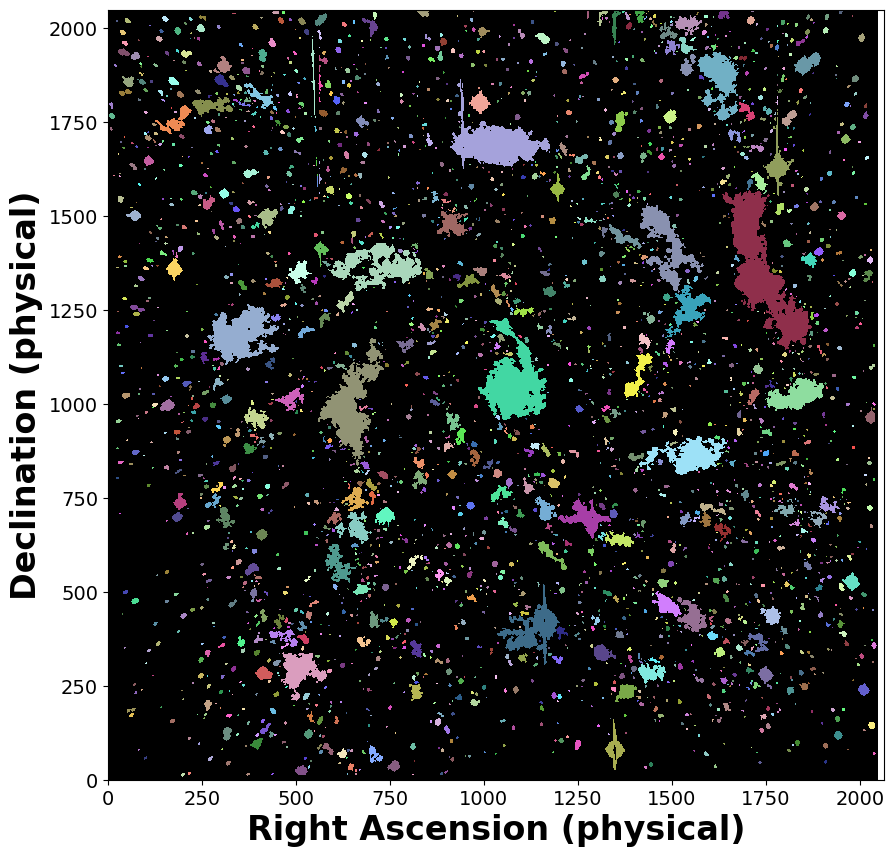

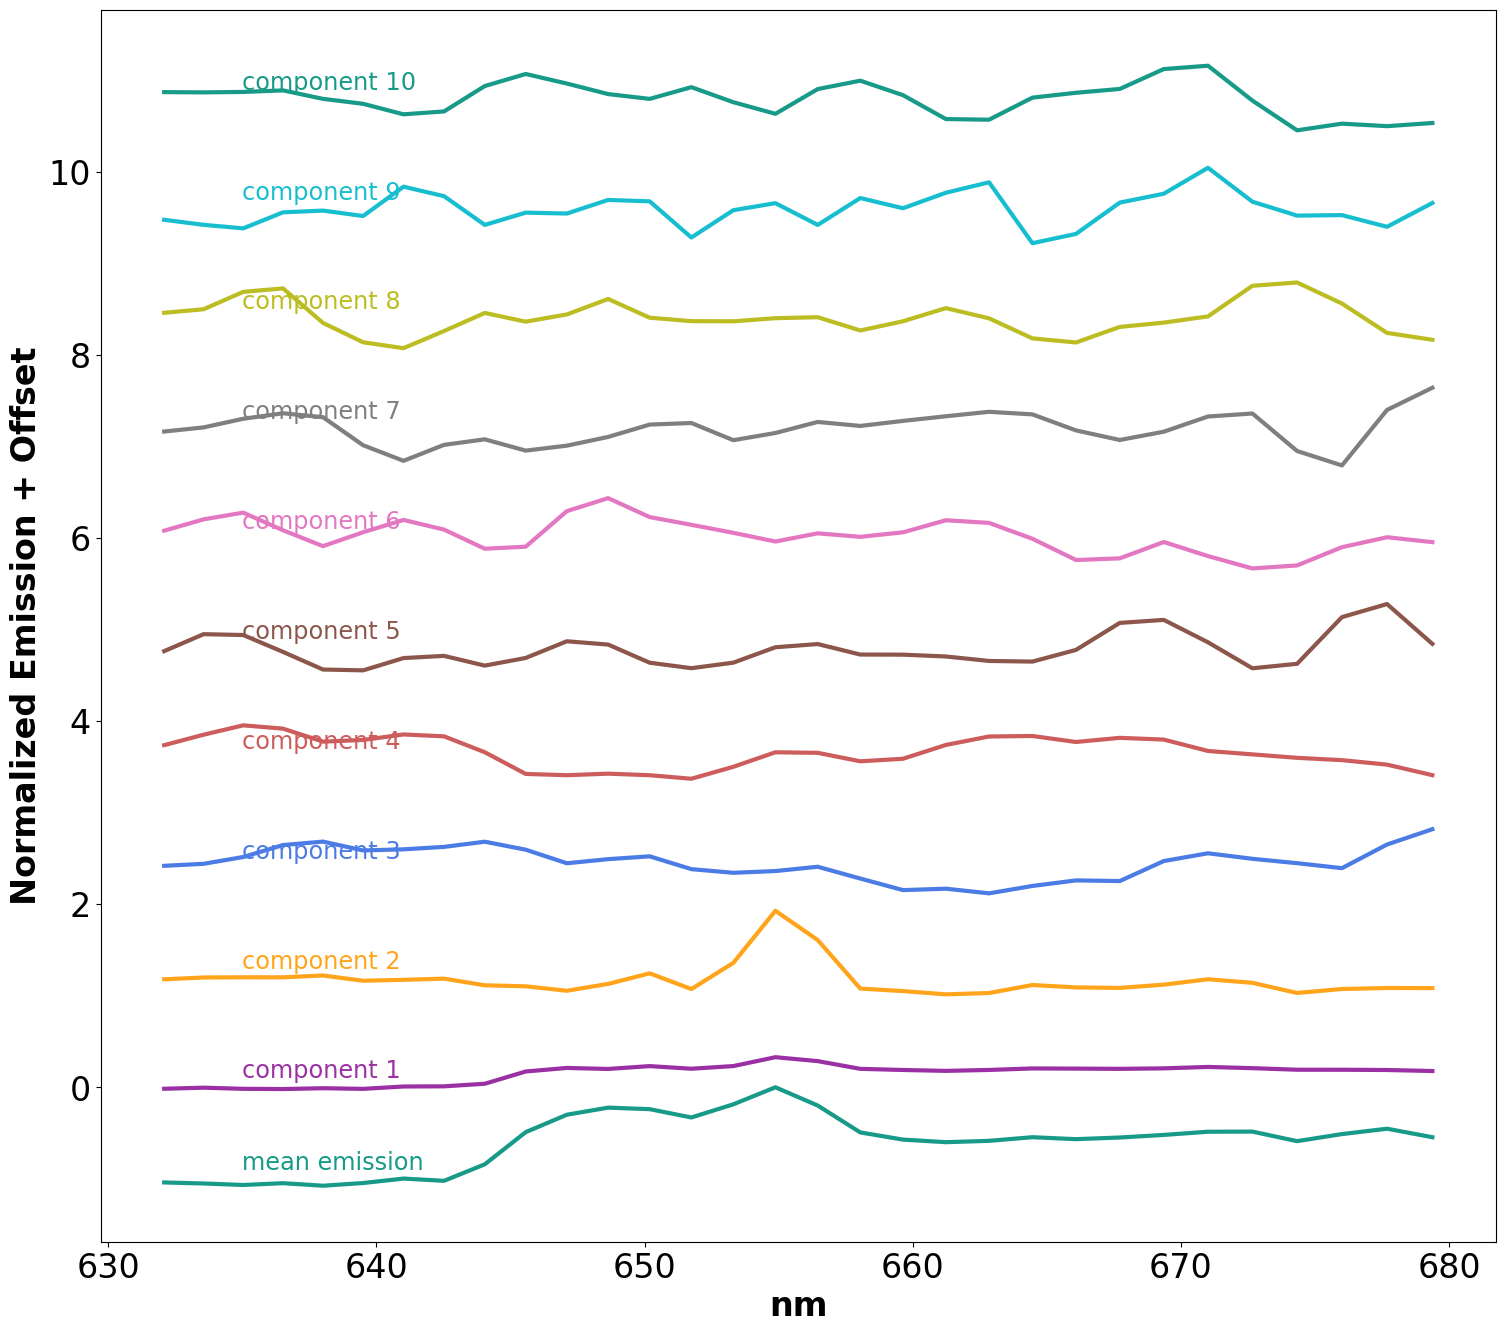

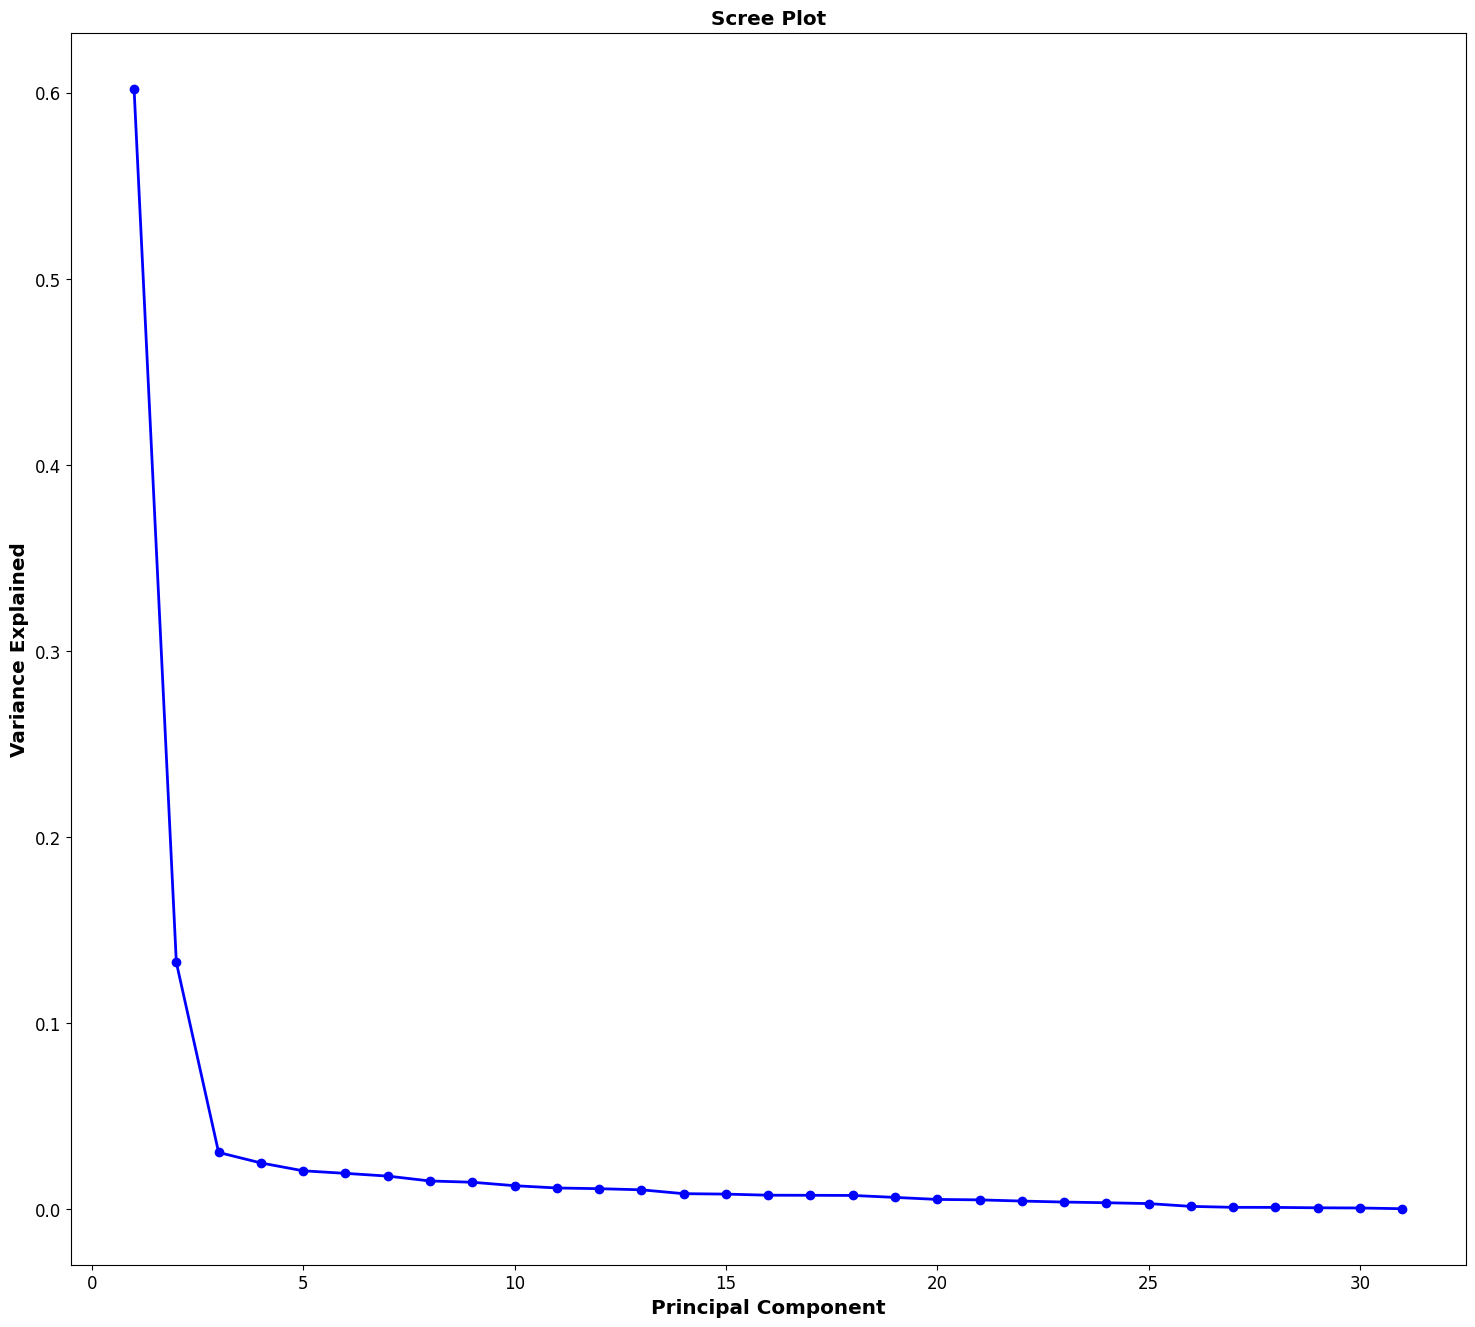

In [4]:
cube.create_background_subspace(x_min=500, x_max=1500, y_min=500, y_max=1500, n_components=n_components, n_components_keep=n_components_keep)